In [78]:
"""
from sklearn.datasets import load_breast_cancer
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

raw_data = load_breast_cancer()
x_data = pd.DataFrame(raw_data['data'],columns=raw_data['feature_names'])
y_data = pd.DataFrame(raw_data['target'],columns=['target'])

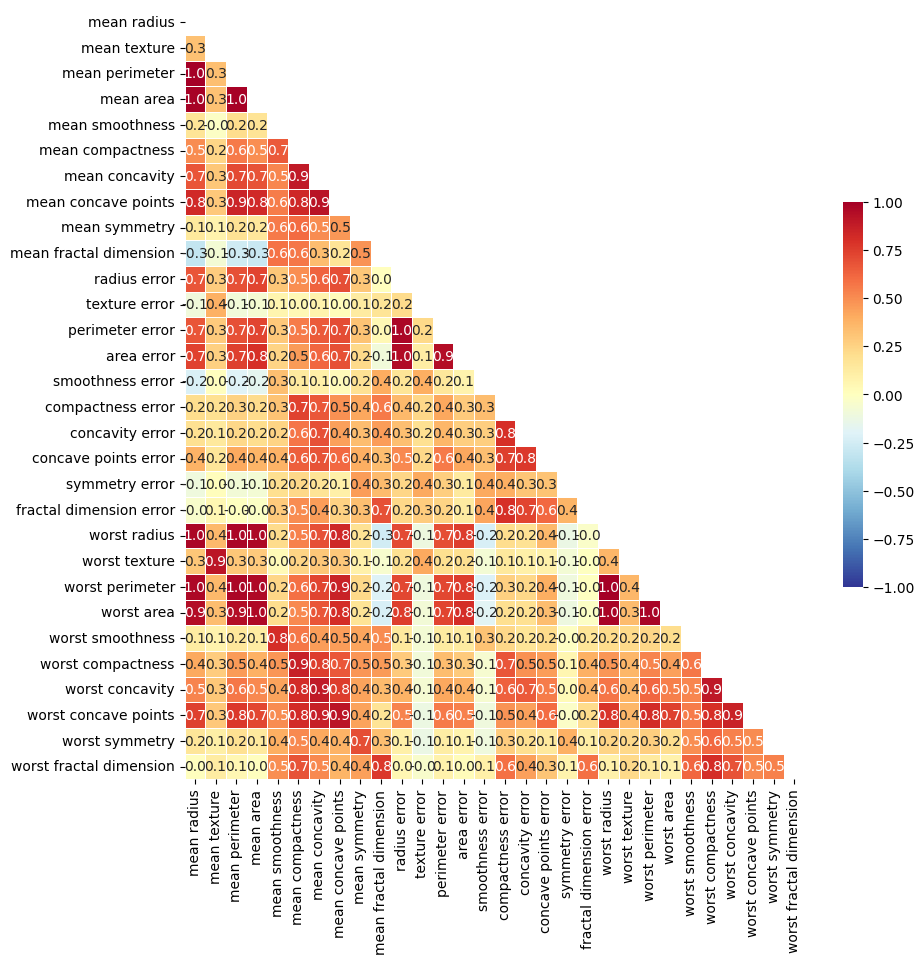

In [79]:
mask = np.zeros_like(x_data.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,10))
sns.heatmap(x_data.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   
            mask=mask,      
            linewidths=.5,
            fmt='.1f',  
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1   
           )  
plt.show()

## not that usefull

In [80]:
# corr over 0.8
corr_matrix = x_data.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

sol[sol > 0.8]

mean radius          mean perimeter             0.997855
worst radius         worst perimeter            0.993708
mean radius          mean area                  0.987357
mean perimeter       mean area                  0.986507
worst radius         worst area                 0.984015
worst perimeter      worst area                 0.977578
radius error         perimeter error            0.972794
mean perimeter       worst perimeter            0.970387
mean radius          worst radius               0.969539
mean perimeter       worst radius               0.969476
mean radius          worst perimeter            0.965137
mean area            worst radius               0.962746
                     worst area                 0.959213
                     worst perimeter            0.959120
radius error         area error                 0.951830
mean perimeter       worst area                 0.941550
mean radius          worst area                 0.941082
perimeter error      area error

In [81]:
ssc = StandardScaler()
x_data.iloc[:,:]=ssc.fit_transform(x_data)
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,
                                                 test_size=0.2,
                                                 shuffle=True,
                                                 stratify=y_data)

In [82]:
"""
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_data,y_data)
plt.plot(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_ > 1e-2)
"""

'\nfrom sklearn.decomposition import PCA\npca = PCA()\npca.fit(x_data,y_data)\nplt.plot(pca.explained_variance_ratio_)\nsum(pca.explained_variance_ratio_ > 1e-2)\n'

### Modeling
```
 1. tf_low
 2. tf_high
 3. torch_low
 4. torch_high
 ```

In [83]:
# 1. tf_low

## layer_1
import tensorflow as tf

x = tf.constant(x_train.values, tf.float32)
y = tf.constant(y_train.values.reshape(-1,1), tf.float32)

initX = tf.initializers.GlorotUniform()
w = tf.Variable(initX(shape=[30,1]))
b = tf.Variable(initX(shape=[1]))

def cost():
    z = tf.matmul(x,w) + b
    c_i = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=z)
    c = tf.reduce_mean(c_i)
    return c

def hxFn(x_data):
    xd = tf.constant(x_data,tf.float32)
    z = tf.matmul(xd,w) + b
    hx = tf.nn.sigmoid(z)
    return (hx.numpy()>0.5) +0

optimizer = tf.keras.optimizers.Adam(0.1)
for i in range(100):
    optimizer.minimize(cost,var_list=[w,b])
    print(i,'cost: ', cost().numpy(), 'acc : ',accuracy_score(y_train,hxFn(x_train)))


/opt/homebrew/Caskroom/miniforge/base/envs/deep_learning/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0 cost:  0.4563313 acc :  0.8087912087912088
1 cost:  0.29098144 acc :  0.8791208791208791
2 cost:  0.21134971 acc :  0.9010989010989011
3 cost:  0.16830441 acc :  0.9230769230769231
4 cost:  0.14299089 acc :  0.9406593406593406
5 cost:  0.1257092 acc :  0.9582417582417583
6 cost:  0.11322428 acc :  0.9626373626373627
7 cost:  0.103922516 acc :  0.9648351648351648
8 cost:  0.09681712 acc :  0.967032967032967
9 cost:  0.09127607 acc :  0.9736263736263736
10 cost:  0.08687561 acc :  0.9758241758241758
11 cost:  0.08331568 acc :  0.9758241758241758
12 cost:  0.080373555 acc :  0.9736263736263736
13 cost:  0.07787888 acc :  0.9736263736263736
14 cost:  0.075699896 acc :  0.9736263736263736
15 cost:  0.07373606 acc :  0.9714285714285714
16 cost:  0.071913905 acc :  0.9736263736263736
17 cost:  0.07018497 acc :  0.9736263736263736
18 cost:  0.068524905 acc :  0.9758241758241758
19 cost:  0.06693269 acc :  0.9758241758241758
20 cost:  0.06542708 acc :  0.9758241758241758
21 cost:  0.06403519 

In [84]:
y_pred=hxFn(x_test.iloc[0,:].values.reshape(1,-1))
print('test 0 번째 ' , y_pred)

test 0 번째  [[1]]


train f1 =>0.9895104895104895
test f1 =>0.993103448275862


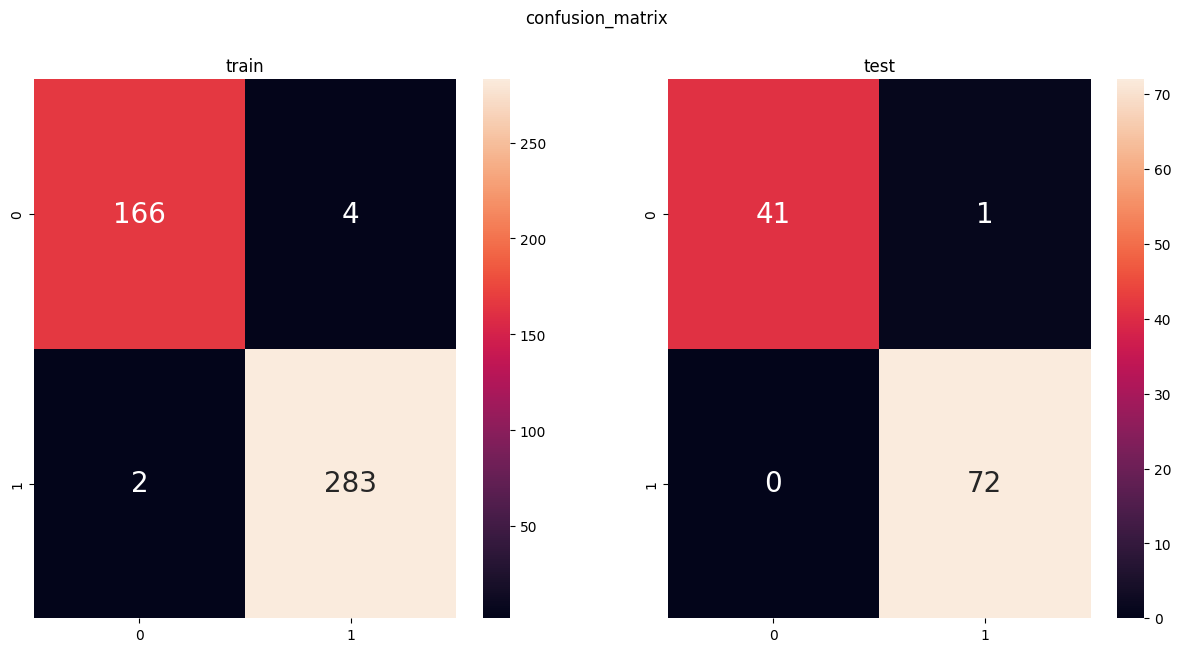

In [85]:
print(f'train f1 =>{f1_score(y_train,hxFn(x_train))}')
print(f'test f1 =>{f1_score(y_test,hxFn(x_test))}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,hxFn(x_train)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,hxFn(x_test)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()

In [86]:
# 1. tf_low

## layer_2
import tensorflow as tf

x = tf.constant(x_data.values, tf.float32)
y = tf.constant(y_data.values.reshape(-1,1), tf.float32)

initX = tf.initializers.GlorotUniform()
w1 = tf.Variable(initX(shape=[30,128]))
b1 = tf.Variable(initX(shape=[128]))

w2 = tf.Variable(initX(shape=[128,1]))
b2 = tf.Variable(initX(shape=[1]))

def cost():
    z1 = tf.matmul(x,w1) + b1
    hx=tf.nn.sigmoid(z1)
    z2 = tf.matmul(hx,w2) + b2
    
    c_i = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=z2)
    c = tf.reduce_mean(c_i)
    return c

def hxFn(x_data):
    xd = tf.constant(x_data,tf.float32)
    z1 = tf.matmul(xd,w1) + b1
    
    hx1=tf.nn.sigmoid(z1)
    z2 = tf.matmul(hx1,w2) + b2
    hx=tf.nn.sigmoid(z2)
    return (hx.numpy() >0.5) +0

optimizer = tf.keras.optimizers.Adam(0.1)
for i in range(100):
    optimizer.minimize(cost,var_list=[w1,w2,b1,b2])
    print(i,'cost: ', cost().numpy(), 'acc : ',accuracy_score(y_train,hxFn(x_train)))


/opt/homebrew/Caskroom/miniforge/base/envs/deep_learning/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0 cost:  1.5695422 acc :  0.4043956043956044
1 cost:  0.38335824 acc :  0.8879120879120879
2 cost:  0.22877972 acc :  0.9274725274725275
3 cost:  0.2093164 acc :  0.9274725274725275
4 cost:  0.22460245 acc :  0.9384615384615385
5 cost:  0.2623668 acc :  0.9384615384615385
6 cost:  0.26362935 acc :  0.9428571428571428
7 cost:  0.21216317 acc :  0.9560439560439561
8 cost:  0.16550726 acc :  0.9560439560439561
9 cost:  0.14077836 acc :  0.9692307692307692
10 cost:  0.13196038 acc :  0.9714285714285714
11 cost:  0.1308227 acc :  0.9714285714285714
12 cost:  0.13375401 acc :  0.9736263736263736
13 cost:  0.13864471 acc :  0.9736263736263736
14 cost:  0.14328995 acc :  0.9714285714285714
15 cost:  0.14585572 acc :  0.9692307692307692
16 cost:  0.14579566 acc :  0.9692307692307692
17 cost:  0.14339596 acc :  0.9692307692307692
18 cost:  0.13959853 acc :  0.9692307692307692
19 cost:  0.13557369 acc :  0.9714285714285714
20 cost:  0.13145426 acc :  0.9714285714285714
21 cost:  0.12680633 acc : 

In [87]:
y_pred=hxFn(x_test.iloc[0,:].values.reshape(1,-1))
print('test 0 번째 ' , y_pred)

test 0 번째  [[1]]


train f1 =>0.9965034965034965
test f1 =>0.993103448275862


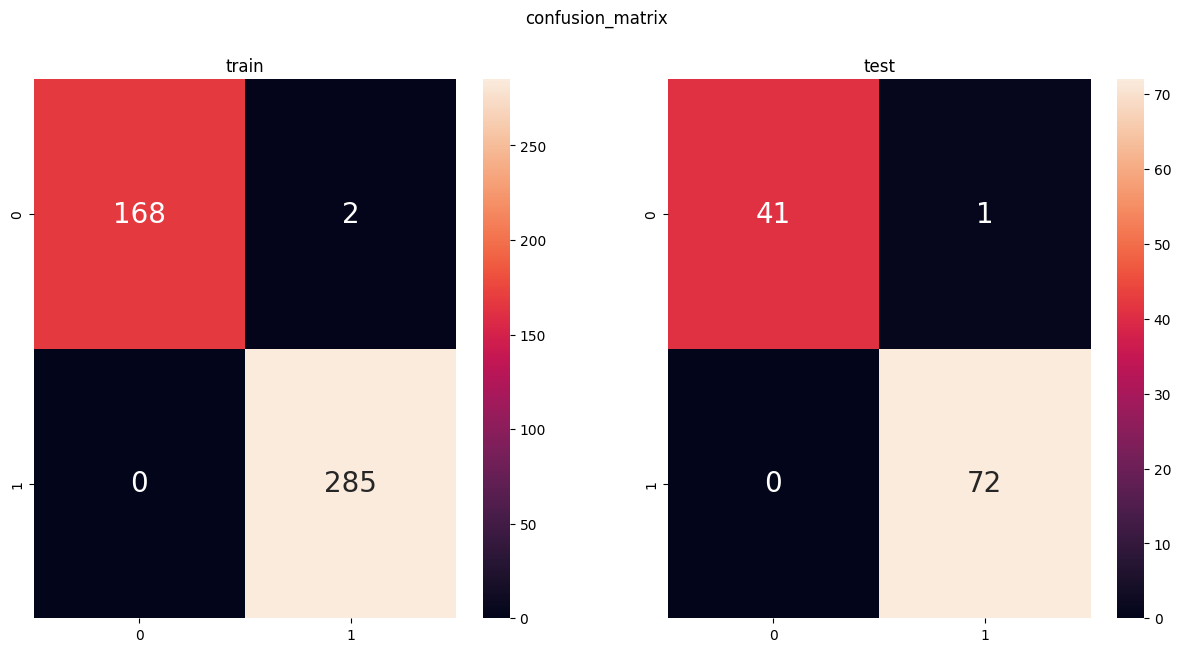

In [88]:
print(f'train f1 =>{f1_score(y_train,hxFn(x_train))}')
print(f'test f1 =>{f1_score(y_test,hxFn(x_test))}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,hxFn(x_train)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,hxFn(x_test)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=128,input_dim=30,activation='sigmoid'))
model.add(Dense(units=1,input_dim=128,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.1), metrics=['acc'])
h =model.fit(x_data,y_data,epochs=100)

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 0.4519 - acc: 0.8352

2022-12-03 15:31:59.606773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 7ms/step - loss: 0.3267 - acc: 0.8875
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.1425 - acc: 0.9684
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0763 - acc: 0.9807
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0705 - acc: 0.9824
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0544 - acc: 0.9859
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0412 - acc: 0.9859
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0451 - acc: 0.9842
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0333 - acc: 0.9859
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0244 - acc: 0.9912
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0255 - acc: 0.9895
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - los

In [90]:
y_pred=(model.predict(x_test.iloc[0,:].values.reshape(1,-1),verbose=0)>0.5)+0
print('test 0 번째 ' , y_pred)

test 0 번째  [[1]]


2022-12-03 15:32:09.780004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


train f1 =>1.0


2022-12-03 15:32:09.861559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


test f1 =>1.0


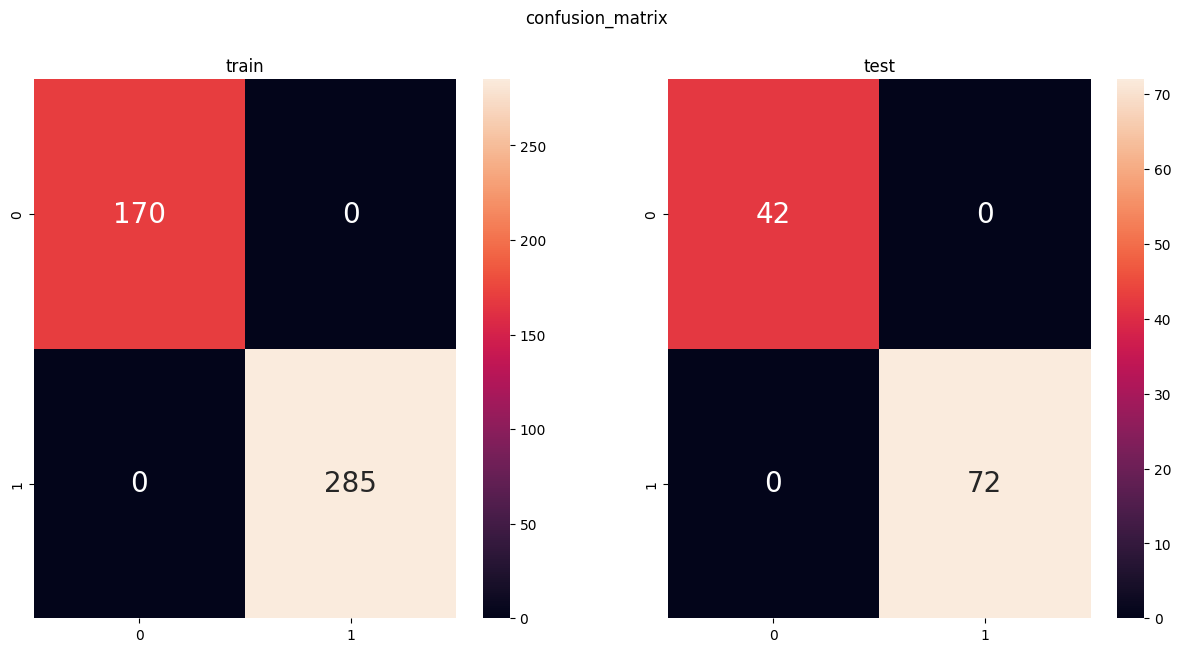

In [91]:
print(f'train f1 =>{f1_score(y_train,(model.predict(x_train,verbose=0)>0.5)+0)}')
print(f'test f1 =>{f1_score(y_test,(model.predict(x_test,verbose=0)>0.5)+0)}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,(model.predict(x_train,verbose=0)>0.5)+0),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,(model.predict(x_test,verbose=0)>0.5)+0),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()

In [92]:
#3. torch_low

# 1_layer
import torch
x = torch.FloatTensor(x_train.values)
y = torch.FloatTensor(y_train.values)

w = torch.empty([x.shape[-1],1],requires_grad=True)
torch.nn.init.uniform_(w)

b = torch.empty([1],requires_grad=True)
torch.nn.init.uniform_(b)


def cost():
    x_hat = torch.matmul(x,w) + b
    c_i = torch.binary_cross_entropy_with_logits(x_hat,y)
    c = torch.mean(c_i)
    return c

def hxFn(x_data):
    xd = torch.FloatTensor(x_data)
    z = torch.matmul(xd,w)
    x_hat = torch.sigmoid(z)
    return (x_hat.detach().numpy() > 0.5) + 0

optimizer = torch.optim.Adam(params=[w,b],lr=0.1)

for i in range(1000):
    c = cost()
    optimizer.zero_grad()
    c.backward()
    optimizer.step()
    acc = accuracy_score(y_train,hxFn(x_train.values))
    print(f'epoch => {i} / cost => {cost().item()} acc => {acc} ')

epoch => 0 / cost => 5.215122699737549 acc => 0.14945054945054945 
epoch => 1 / cost => 3.8453190326690674 acc => 0.16043956043956045 
epoch => 2 / cost => 2.540982723236084 acc => 0.18461538461538463 
epoch => 3 / cost => 1.3968641757965088 acc => 0.2725274725274725 
epoch => 4 / cost => 0.6149802803993225 acc => 0.6615384615384615 
epoch => 5 / cost => 0.318951278924942 acc => 0.8857142857142857 
epoch => 6 / cost => 0.25529348850250244 acc => 0.8901098901098901 
epoch => 7 / cost => 0.25439387559890747 acc => 0.8945054945054945 
epoch => 8 / cost => 0.26579180359840393 acc => 0.9010989010989011 
epoch => 9 / cost => 0.2753066420555115 acc => 0.9032967032967033 
epoch => 10 / cost => 0.27939674258232117 acc => 0.9010989010989011 
epoch => 11 / cost => 0.27776727080345154 acc => 0.9032967032967033 
epoch => 12 / cost => 0.2711494565010071 acc => 0.9032967032967033 
epoch => 13 / cost => 0.2606094479560852 acc => 0.9076923076923077 
epoch => 14 / cost => 0.24720340967178345 acc => 0.91

train f1 =>0.993006993006993
test f1 =>0.993103448275862


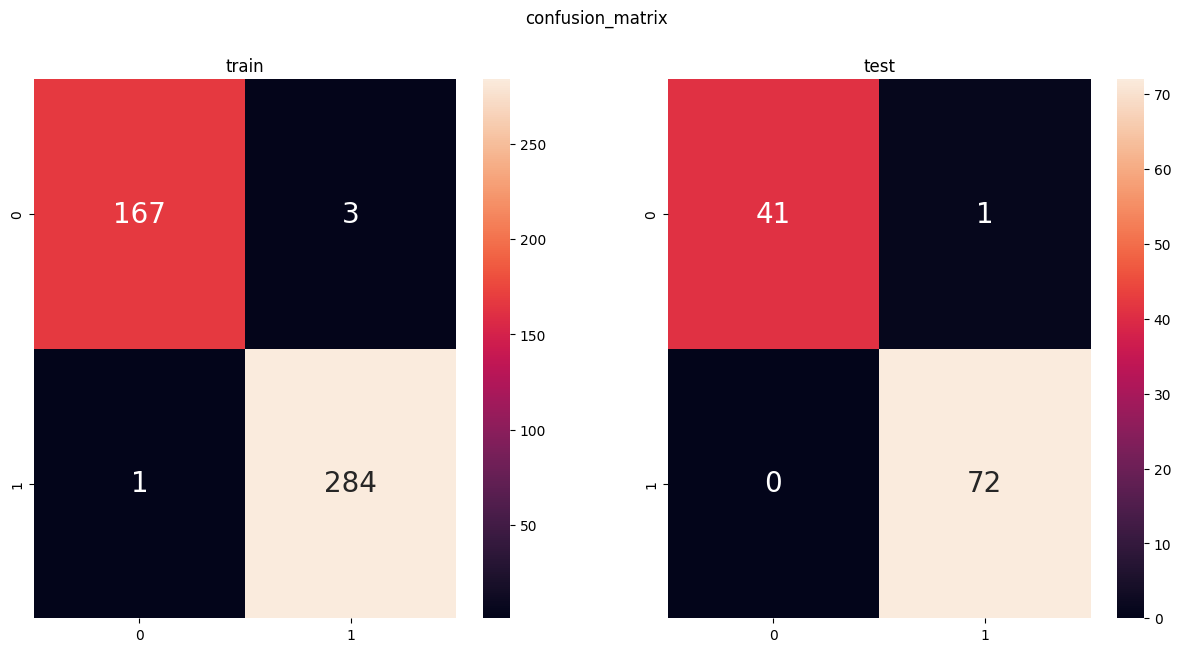

In [93]:
print(f'train f1 =>{f1_score(y_train,hxFn(x_train.values))}')
print(f'test f1 =>{f1_score(y_test,hxFn(x_test.values))}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,hxFn(x_train.values)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,hxFn(x_test.values)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()

In [94]:
#3. torch_low

# 2_layer
import torch
x = torch.FloatTensor(x_train.values)
y = torch.FloatTensor(y_train.values)

w1 = torch.empty([x.shape[-1],64],requires_grad=True)
torch.nn.init.uniform_(w1)
b1 = torch.empty([64],requires_grad=True)
torch.nn.init.uniform_(b1)

w2 = torch.empty([64,1],requires_grad=True)
torch.nn.init.uniform_(w2)
b2 = torch.empty([1],requires_grad=True)
torch.nn.init.uniform_(b2)

def cost():
    x_h_1 = torch.matmul(x,w1) + b1
    x_h_2 = torch.matmul(x_h_1,w2) + b2
    
    c_i = torch.binary_cross_entropy_with_logits(x_h_2,y)
    c = torch.mean(c_i)
    return c

def hxFn(x_data):
    xd = torch.FloatTensor(x_data)
    x_h_1 = torch.matmul(xd,w1) + b1
    x_h_2 = torch.matmul(x_h_1,w2) + b2
    x_hat = torch.sigmoid(x_h_2)
    return (x_hat.detach().numpy() > 0.5) + 0

optimizer = torch.optim.Adam(params=[w1,w2,b1,b2],lr=0.1)

for i in range(1000):
    c = cost()
    optimizer.zero_grad()
    c.backward()
    optimizer.step()
    acc = accuracy_score(y_train,hxFn(x_train.values))
    print(f'epoch => {i} / cost => {cost().item()} acc => {acc} ')

epoch => 0 / cost => 149.963134765625 acc => 0.14065934065934066 
epoch => 1 / cost => 83.95032501220703 acc => 0.15384615384615385 
epoch => 2 / cost => 32.775146484375 acc => 0.1824175824175824 
epoch => 3 / cost => 1.361069917678833 acc => 0.7406593406593407 
epoch => 4 / cost => 1.7940977811813354 acc => 0.8989010989010989 
epoch => 5 / cost => 2.61279034614563 acc => 0.8967032967032967 
epoch => 6 / cost => 2.7378480434417725 acc => 0.9010989010989011 
epoch => 7 / cost => 2.3440475463867188 acc => 0.9142857142857143 
epoch => 8 / cost => 1.6513811349868774 acc => 0.9274725274725275 
epoch => 9 / cost => 0.9456875920295715 acc => 0.9274725274725275 
epoch => 10 / cost => 0.7261679768562317 acc => 0.9252747252747253 
epoch => 11 / cost => 1.1358948945999146 acc => 0.8989010989010989 
epoch => 12 / cost => 1.9834791421890259 acc => 0.8615384615384616 
epoch => 13 / cost => 2.6220815181732178 acc => 0.8285714285714286 
epoch => 14 / cost => 2.4644243717193604 acc => 0.830769230769230

train f1 =>1.0
test f1 =>0.9863013698630138


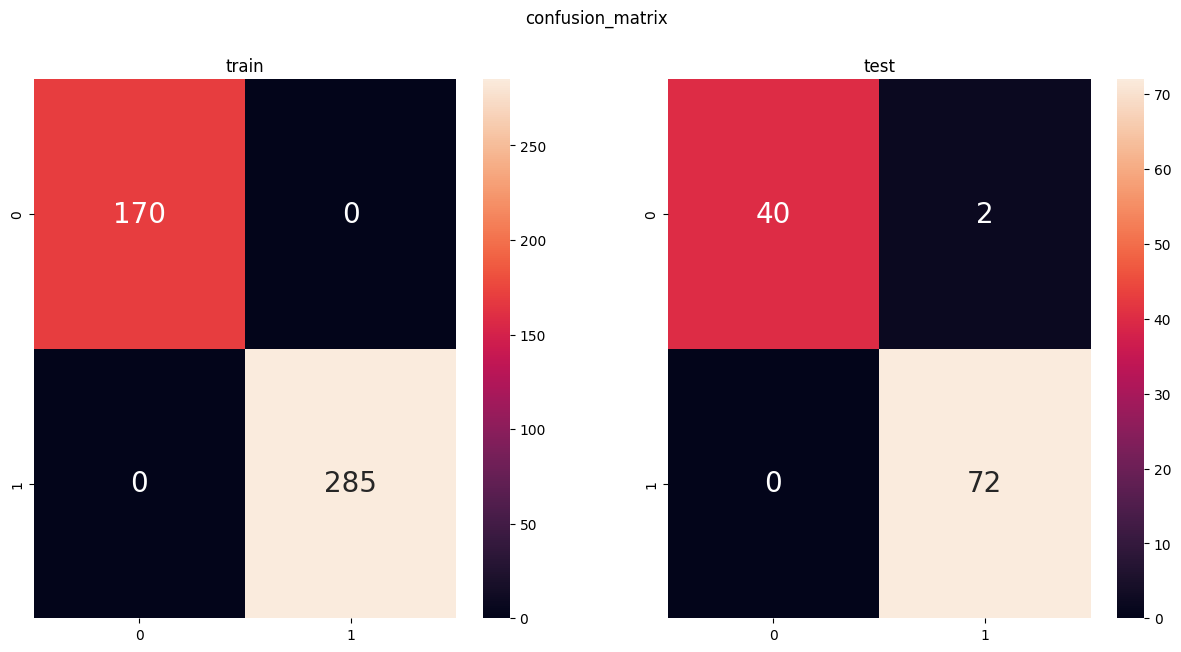

In [95]:
print(f'train f1 =>{f1_score(y_train,hxFn(x_train.values))}')
print(f'test f1 =>{f1_score(y_test,hxFn(x_test.values))}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,hxFn(x_train.values)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,hxFn(x_test.values)),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()

In [96]:
# 4. torch_high

x = torch.FloatTensor(x_train.values)
y = torch.FloatTensor(y_train.values)

model = torch.nn.Sequential()
model.add_module('linear1',torch.nn.Linear(x.shape[-1],64))
model.add_module('linear2',torch.nn.Linear(64,1))
model.add_module('sigmoid',torch.nn.Sigmoid())
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    hx = model(x)
    """
    => x:(455,30)
    => linear1 -> (455,30) => (455,64)
    => linear2 -> (455,64) => (455, 1)
    => sigmoid -> (455,1) => (455,1)
    """
    c = loss_fn(hx,y)
    c.backward()
    optimizer.step()
    pred = (hx.detach().numpy() > 0.5)+0
    print(f'epoch => {epoch} / cost => {c.detach().numpy()} \
          acc => {accuracy_score(pred,y)} ')

epoch => 0 / cost => 0.816951334476471           acc => 0.2549450549450549 
epoch => 1 / cost => 0.2683592140674591           acc => 0.9142857142857143 
epoch => 2 / cost => 0.25191447138786316           acc => 0.8835164835164835 
epoch => 3 / cost => 0.11297629028558731           acc => 0.967032967032967 
epoch => 4 / cost => 0.21558210253715515           acc => 0.9538461538461539 
epoch => 5 / cost => 0.19018948078155518           acc => 0.9714285714285714 
epoch => 6 / cost => 0.1707451492547989           acc => 0.978021978021978 
epoch => 7 / cost => 0.16193419694900513           acc => 0.978021978021978 
epoch => 8 / cost => 0.1641971468925476           acc => 0.9758241758241758 
epoch => 9 / cost => 0.1749623715877533           acc => 0.9692307692307692 
epoch => 10 / cost => 0.16990967094898224           acc => 0.9692307692307692 
epoch => 11 / cost => 0.15492574870586395           acc => 0.9736263736263736 
epoch => 12 / cost => 0.1412103772163391           acc => 0.97582417582

train f1 =>1.0
test f1 =>0.9863013698630138


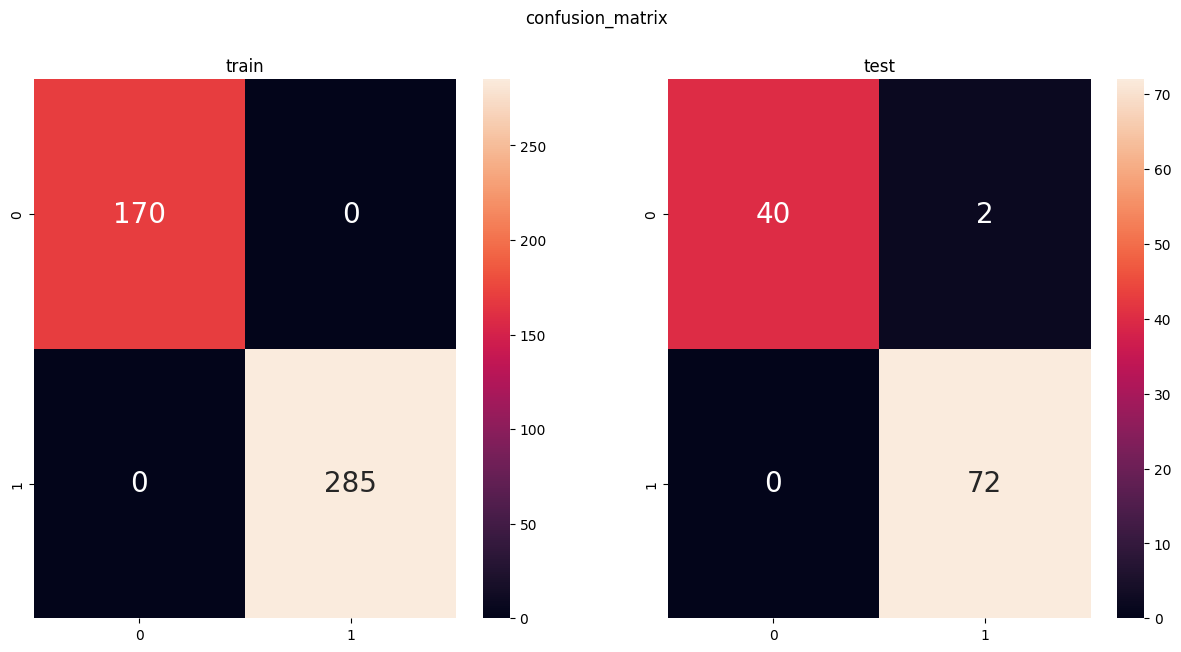

In [97]:
x_train_tensor = torch.FloatTensor(x_train.values)
x_test_tensor = torch.FloatTensor(x_test.values)

print(f'train f1 =>{f1_score(y_train,(model(x_train_tensor).detach().numpy()>0.5)+0)}')
print(f'test f1 =>{f1_score(y_test,(model(x_test_tensor).detach().numpy()>0.5)+0)}')

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(
    confusion_matrix(y_train,(model(x_train_tensor).detach().numpy()>0.5)+0),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('train')
plt.subplot(1,2,2)
sns.heatmap(
    confusion_matrix(y_test,(model(x_test_tensor).detach().numpy()>0.5)+0),
    annot=True,
    annot_kws={"size": 20},
    fmt=".0f")
plt.title('test')
plt.suptitle('confusion_matrix')
plt.show()